# Vietnamese News Classification

#GPU Information


In [ ]:
!nvidia-smi

Fri Sep 17 13:42:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Import Libs

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import regex as re
import random
import math
import os
from tqdm.notebook import tqdm
import pickle

#Load data

Bộ dữ liệu là tổng hợp từ các tin tức tiếng Việt trong và ngoài nước với 27 topics khác nhau.

Link dataset: https://github.com/duyvuleo/VNTC

Thông tin chi tiết của dataset

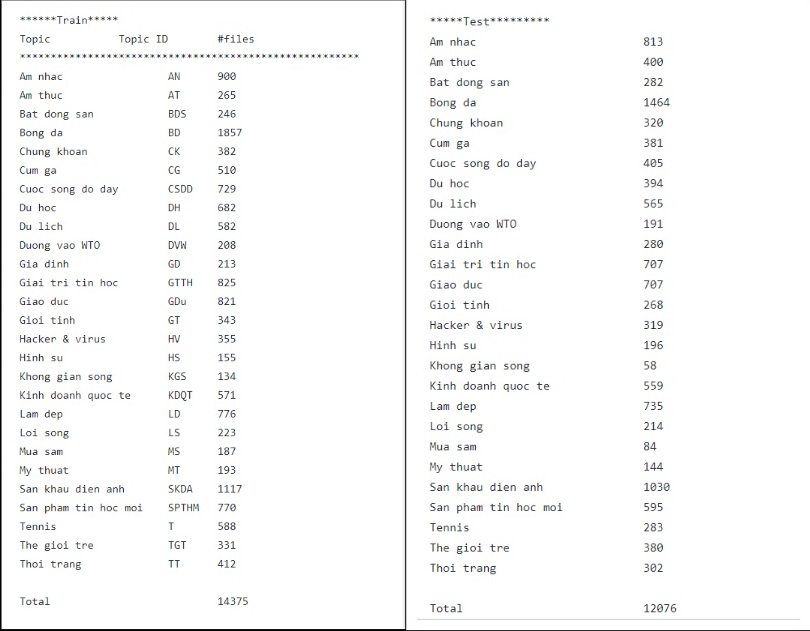

In [ ]:
# Đường dẫn tới thư mục chứa data
test_dir = '/content/drive/MyDrive/The Anh Tran/Final Coursework/Data/Test'
train_dir = '/content/drive/MyDrive/The Anh Tran/Final Coursework/Data/Train'

**Danh sách nhãn**

In [ ]:
# Thư mục có tên là nhãn của các bài báo trong thư mục đó
labels = os.listdir(train_dir)
print('Number of labels: ', len(labels))
labels

Number of labels:  27


['San khau dien anh',
 'San pham tin hoc moi',
 'Kinh doanh quoc te',
 'Tennis',
 'Lam dep',
 'Hinh su',
 'My thuat',
 'Khong gian song',
 'Loi song',
 'Mua sam',
 'Bat dong san',
 'Bong da',
 'Cum ga',
 'Am nhac',
 'The gioi tre',
 'Am thuc',
 'Cuoc song do day',
 'Du hoc',
 'Chung khoan',
 'Thoi trang',
 'Duong vao WTO',
 'Giai tri tin hoc',
 'Du lich',
 'Gioi tinh',
 'Hackers va Virus',
 'Gia dinh',
 'Giao duc']

**Load dữ liệu tập train từ file**

In [ ]:
# Liệt kê đường dẫn tới tất cả các tệp văn bản trong tập train
train_paths = []

for label in tqdm(labels):
  dir_path = train_dir + '/' + label
  news_paths = os.listdir(dir_path)
  for path in news_paths:
    train_paths.append(dir_path + '/' + path)

print('Done')

  0%|          | 0/27 [00:00<?, ?it/s]

Done


In [ ]:
# Một file
with open(train_paths[1],'r', encoding='utf-16') as f:
    contents = f.read()
    print(contents)

Hậu trường 'Những cô gái xinh đẹp'
Bộ phim là câu chuyện tình cảm lãng mạn, tuy nhiên, quá trình thực hiện lại chẳng thi vị chút nào. Ngoài Thi Dịch Nam và Hoắc Kiến Hoa bị tai nạn, Diệp An Đình do đóng phim lần đầu nên bị áp lực, mắc chứng trầm cảm.
Không chỉ thế, diễn viên Khưu Kỳ Văn bị một fan quá khích tấn công khiến cô hoảng sợ, gây ảnh hưởng đến tiến độ làm phim. Tuy nhiên, bộ phim được khán giả Đài Loan đón nhận nồng nhiệt, trở thành một trong những tác phẩm truyền hình ăn khách nhất năm 2003. Từ kế hoạch 20 tập ban đầu, do cảm thấy "ăn", đạo diễn quyết định làm thêm 4 tập. 
Nụ hôn đáng nhớ của chàng Tử Tường
Thi Dịch Nam xuất thân là ca sĩ, nhưng thành danh trên màn ảnh. Gần như phim nào cũng được hôn, nhưng đáng nhớ nhất vẫn là kỷ niệm nồng say cùng An Đình. Theo kịch bản, sau khi đánh rơi chiếc nhẫn xuống hồ bơi, nhân vật Tử Tường vội nhảy xuống tìm, trao cho Phương Dĩnh rồi 2 người có nụ hôn say đắm. Chẳng biết nhảy thế nào mà Dịch Nam bị trật tay phải nên khi chuyển sang c

In [ ]:
# Đọc tất cả các file và label tương ứng của chúng
train_x = []
train_y = []

for path in tqdm(train_paths):
  with open(path, 'r', encoding='utf-16') as f:
    content = f.read()
    label = path.split(os.path.sep)[-2]
    train_x.append(content)
    train_y.append(label)

  0%|          | 0/14375 [00:00<?, ?it/s]

In [ ]:
print('Train size: ', len(train_x))

Train size:  14375


In [ ]:
train_x[0]

'Mỗi đạo diễn chỉ được dựng hai vở trong hội diễn\nThông báo mới của Cục Nghệ thuật biểu diễn (Bộ VH-TT) quy định trong hội diễn sân khấu, một đạo diễn không được dựng quá 2 vở, đang làm dư luận xôn xao... Cục trưởng Lê Ngọc Cường đã có ý kiến về vấn đề này.\n- Văn bản này sẽ được thực thi như thế nào, thưa ông?\n- Chúng tôi đã thảo thông báo gửi tới các đơn vị nghệ thuật sẽ tham gia 5 hội diễn trong năm 2005 (Tuồng - tháng 5, cải lương - dịp 30/4, chèo - tháng 10, và 2 hội diễn ca múa nhạc - tháng 6 đối với phía Bắc, tháng 10 đối với phía Nam). Tới đây, Cục sẽ soạn thảo quy chế.\n- Trong bối cảnh các đoàn đều phải theo cơ chế thị trường, sân khấu được kêu gọi xã hội hoá, việc hạn chế đạo diễn như thế sẽ chơi khó các đoàn, ông nghĩ sao?\n- Chính vì xã hội hoá hoạt động sân khấu nên càng cần tạo điều kiện cho nhiều đạo diễn tham gia. Không để cho lớp trẻ tham gia sẽ gây trống trải cả một thế hệ. Dư luận đang kêu ca chất lượng sân khấu không được nâng cao, nhiều đạo diễn gạo cội đang đi 

**Load dữ liệu tập test từ file**

In [ ]:
# Liệt kê đường dẫn tới tất cả các tệp văn bản trong tập test
test_paths = []

for label in tqdm(labels):
  dir_path = test_dir + '/' + label
  news_paths = os.listdir(dir_path)
  for path in news_paths:
    test_paths.append(dir_path + '/' + path)

print('Done')

  0%|          | 0/27 [00:00<?, ?it/s]

Done


In [ ]:
# Đọc tất cả các file và label tương ứng của chúng
test_x = []
test_y = []

for path in tqdm(test_paths):
  with open(path, 'r', encoding='utf-16') as f:
    content = f.read()
    label = path.split(os.path.sep)[-2]
    test_x.append(content)
    test_y.append(label)

print('Test size: ', len(test_x))

  0%|          | 0/12076 [00:00<?, ?it/s]

Test size:  12076


**Save dữ liệu**

In [ ]:
train_x = pickle.load(open('/content/drive/MyDrive/The Anh Tran/Final Coursework/Data/train_x.sav', 'rb'))
train_y = pickle.load(open('/content/drive/MyDrive/The Anh Tran/Final Coursework/Data/train_y.sav', 'rb'))
test_x = pickle.load(open('/content/drive/MyDrive/The Anh Tran/Final Coursework/Data/test_x.sav', 'rb'))
test_y = pickle.load(open('/content/drive/MyDrive/The Anh Tran/Final Coursework/Data/test_y.sav', 'rb'))

In [ ]:
# Test dữ liệu đã load được
random_list = random.sample(range(0, len(train_x) - 1), 5);
for i in random_list:
  print("Cate: ", train_y[i])
  print("Content: ", train_x[i])
  print('-------------------------------')

Cate:  Am thuc
Content:  Khoai tây bọc thịt rán
Khoai tây luộc, giã nhuyễn, trộn đều với thịt nạc băm rồi chiên vàng. Món này dọn ăn nóng.
Nguyên liệu:
- 700g khoai tây, chọn củ to, vàng, nhẵn. 
- 150g thịt nạc vai, 2 quả trứng, một ít bột mỳ. 
- Hành, mùi tây, tiêu, mắm, muối... dầu ăn. 
Thực hiện:
Khoai tây rửa sạch, cho vào luộc chín nhừ, vớt ra bóc vỏ, sau đó cho vào cối giã nhuyễn. Thịt nạc vai băm nhỏ, ướp gia vị, hành, mùi tây thái nhỏ. Trứng đánh đều với bột mỳ để vào đĩa sâu. 
Lấy khoai tây đã giã nhuyễn nặn viên với nhân là thịt đã ướp. 
Đổ dầu vào chảo đun nóng, lần lượt cho những viên khoai tây nhân thịt lăn đều qua hỗn hợp trứng - bột mỳ rồi cho vào chảo rán, cho đến khi vỏ bên ngoài vàng rộp là được. 


-------------------------------
Cate:  Gia dinh
Content:  Khẳng định mình là xu hướng chung của các cá nhân trong xã hội hiện đại ngày nay, bất kỳ ở lứa tuổi, giới tính, lĩnh vực nào… Tuy nhiên, mọi vinh quang của cá nhân sẽ không thể được nói là trọn vẹn nếu đằng sau đó k

**Đánh giá sơ bộ tập dữ liệu**

In [ ]:
# Tính độ dài trung bình của một bản tin thông thường
def sentence_len(text):
  return len(text.split(' '));

len_list = []

for content in train_x:
  len_list.append(sentence_len(content))

print('Average content length: ', np.mean(len_list))

Average content length:  518.9140869565217


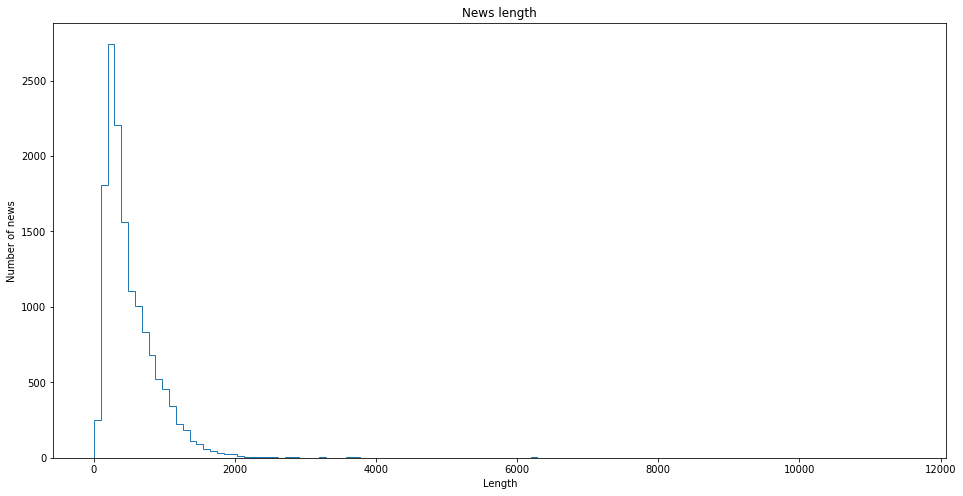

In [ ]:
# Vẽ histogram để quan sát phân bố về độ dài các datapoint
plt.figure(figsize=(16, 8))
plt.title("News length")
plt.xlabel('Length')
plt.ylabel('Number of news')
a = plt.hist(np.array(len_list), bins=int(math.sqrt(len(len_list))), histtype='step')

**Nhận xét:** Phần lớn các bài báo có độ dài từ 0 -> 2000 từ.

#Preprocessing data

Quy trình thực hiện như sau:

  1. Xóa HTML code nếu có
  2. Chuẩn hóa bảng mã Unicode
  3. Chuẩn hóa kiểu gõ dấu tiếng việt (ví dụ òa úy thay cho oà uý)
  4. Thực hiện tách từ tiếng Việt
  5. Đưa về dạng việt thường
  6. Xóa các ký tự đặc biệt

###1. Xóa HTML code

Do dữ liệu các bài báo được thu thập từ các trang web nên sau khi thu thập thì đôi khi vẫn còn sót những ký tự HTML (thẻ đóng, thẻ mở). Vì vậy, đầu tiên, trước khi thực hiện những xử lý phức tạp hơn, ta tiến hành xóa những ký tự HTML còn sót lại trước.

Để thực hiện công việc này hiệu quả, em sử dụng regex hay (Regular Expression).

In [ ]:
# Hàm xóa html
def remove_html(text):
  return re.sub(r'<[^>]*>', '', text)

# Ví dụ
text = '<title>Xin chào <b>Bạn<\b><\title>'
text = remove_html(text)
text

'Xin chào Bạn'

###2. Chuẩn hóa bảng mã Unicode

Hiện nay có 2 loại Unicode được sử dụng là **Unicode tổ hợp** và U**nicode dựng sẵn**. Việc sử dụng văn bản từ 2 bảng mã khác nhau sẽ tạo ra những kết quả sai lệch. Điều này sẽ gây nên những vấn đề như cùng một nội dung nhưng so sánh sẽ ra kết quả False. Nếu không xử lý trường hợp này, thì khi đưa vào mô hình, nó sẽ lầm tưởng những từ giống nhau là khác nhau, từ đó làm rối quá trình học của mô hình.

In [ ]:
'hiếu' == 'hiếu'

True

In [ ]:
'hiếu' == 'hiếu'

False

**Giải pháp:** Để tránh làm nhiễu mô hình, ta sẽ tiến hành đưa hết những bài báo trong dataset về thành kiểu Unicode dựng sẵn.

In [ ]:
uniChars = "àáảãạâầấẩẫậăằắẳẵặèéẻẽẹêềếểễệđìíỉĩịòóỏõọôồốổỗộơờớởỡợùúủũụưừứửữựỳýỷỹỵÀÁẢÃẠÂẦẤẨẪẬĂẰẮẲẴẶÈÉẺẼẸÊỀẾỂỄỆĐÌÍỈĨỊÒÓỎÕỌÔỒỐỔỖỘƠỜỚỞỠỢÙÚỦŨỤƯỪỨỬỮỰỲÝỶỸỴÂĂĐÔƠƯ"
unsignChars = "aaaaaaaaaaaaaaaaaeeeeeeeeeeediiiiiooooooooooooooooouuuuuuuuuuuyyyyyAAAAAAAAAAAAAAAAAEEEEEEEEEEEDIIIOOOOOOOOOOOOOOOOOOOUUUUUUUUUUUYYYYYAADOOU"
 
# Hàm tạo dict để convert định dạng cũ sang định dạng mới
def loaddicchar():
  dic = {}
  char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'.split('|')
  charutf8 = "à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ".split('|')
  for i in range(len(char1252)):
      dic[char1252[i]] = charutf8[i]
  return dic
  
dicchar = loaddicchar()
 
# Đưa toàn bộ dữ liệu qua hàm này để chuẩn hóa lại
def convert_unicode(txt):
    return re.sub(
        r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
        lambda x: dicchar[x.group()], txt)

In [ ]:
# Kiểm nghiệm
type1 = 'hiếu'  # Loại dựng sẵn
type2 = 'hiếu'  # Loại tổ hợp

# Nếu là loai Unicode dựng sẵn thì sẽ không thay đổi
print(type1 == convert_unicode(type1))

# Nếu là loại Unicode tổ hợp sẽ được đưa về dạng unicode dựng sẵn
print(type1 == convert_unicode(type2))

True
True


###3. Chuẩn hóa kiểu gõ dấu tiếng Việt và đưa về dạng viết thường

+ Lỗi gõ dấu thường xảy ra là do cách đánh máy của người viết báo, do khác bộ mã hoặc đôi khi nó thường xuất hiện trong các văn bản cũ. Tuy nhiên việc khác bộ mã đã được xử lý ở trên, do đó, ở phần này, em sẽ tiến hành sửa những kiểu gõ dấu tiếng Việt khác nhau về cùng loại.
+ Việc chuyển các từ trong câu về dạng viết thường là rất cần thiết, vì đặc trưng này không có nhiều ý nghĩa trong bài toán đang được đặt ra. Việc này sẽ giảm số lượng đặc trưng mà mô hình phải học (viết hoa hay viết thường) từ đó tăng tính chính xác của mô hình

In [ ]:
# Danh sách nguyên âm với các dấu tương ứng
bang_nguyen_am = [['a', 'à', 'á', 'ả', 'ã', 'ạ', 'a'],
                  ['ă', 'ằ', 'ắ', 'ẳ', 'ẵ', 'ặ', 'aw'],
                  ['â', 'ầ', 'ấ', 'ẩ', 'ẫ', 'ậ', 'aa'],
                  ['e', 'è', 'é', 'ẻ', 'ẽ', 'ẹ', 'e'],
                  ['ê', 'ề', 'ế', 'ể', 'ễ', 'ệ', 'ee'],
                  ['i', 'ì', 'í', 'ỉ', 'ĩ', 'ị', 'i'],
                  ['o', 'ò', 'ó', 'ỏ', 'õ', 'ọ', 'o'],
                  ['ô', 'ồ', 'ố', 'ổ', 'ỗ', 'ộ', 'oo'],
                  ['ơ', 'ờ', 'ớ', 'ở', 'ỡ', 'ợ', 'ow'],
                  ['u', 'ù', 'ú', 'ủ', 'ũ', 'ụ', 'u'],
                  ['ư', 'ừ', 'ứ', 'ử', 'ữ', 'ự', 'uw'],
                  ['y', 'ỳ', 'ý', 'ỷ', 'ỹ', 'ỵ', 'y']]
# Bảng chứa ký tự dấu ứng: dấu trắng, dấu huyền, sắc, hỏi, ngã, nặng ứng với các cột bên trên
bang_ky_tu_dau =  [ '', 'f', 's', 'r', 'x', 'j']

# dict để chuyển ký tự unicode sang chỉ số (i, j) trong đó i đặc trưng cho nguyên âm nào còn j đặc trưng cho dấu
nguyen_am_to_ids = {}

# Khởi tạo dict
for i in range(len(bang_nguyen_am)):
    for j in range(len(bang_nguyen_am[i]) - 1):
        nguyen_am_to_ids[bang_nguyen_am[i][j]] = (i, j)

# Kiểm tra tính hợp lệ của một từ tiếng Việt đã được gõ đúng hay chưa dựa trên tính chất là:
# Các nguyên âm trong tiếng việt sẽ đứng cạnh nhau tạo thành cụm và mỗi từ chỉ có tối đa 1 cụm nguyên âm
# Ví dụ: Nguyễn -> Ng(uyễ)n, Thắng -> Th(ắ)ng, Hảo -> H(ảo)
def is_valid_vietnam_word(word):
    chars = list(word)
    nguyen_am_index = -1

    # duyệt từng ký tự trong word
    for index, char in enumerate(chars):
        x, y = nguyen_am_to_ids.get(char, (-1, -1)) # x xác định nguyên âm nào còn y sẽ xác định dấu ứng với nguyên âm đó
        if x != -1: # nếu char là nguyên âm
            if nguyen_am_index == -1: # nếu chưa tìm thấy nguyên âm
                nguyen_am_index = index
            else:                     # đã tìm thấy nguyên âm
                if index - nguyen_am_index != 1: # nếu nguyên âm tìm thấy ko nằm cạnh nguyên âm đã tìm thấy
                    return False
                nguyen_am_index = index
    return True
 
print("Nguyene: ", is_valid_vietnam_word("Nguyene"))
print('Nguyễn: ', is_valid_vietnam_word('Nguyễn'))

Nguyene:  False
Nguyễn:  True


In [ ]:
# Thực hiện chuẩn hóa dấu cho từng từ trong tiếng Việt
def chuan_hoa_dau_tu_tieng_viet(word):
    # Nếu là invalid word thì sẽ không xử lý bao gồm từ tiếng anh, số, từ gõ sai, ...
    if not is_valid_vietnam_word(word):
        return word

    chars = list(word)
    dau_cau = 0
    nguyen_am_index = []
    qu_or_gi = False

    # Duyệt qua từng ký tự
    for index, char in enumerate(chars):
        x, y = nguyen_am_to_ids.get(char, (-1, -1))
        if x == -1: # Nếu char là phụ âm
            continue

        elif x == 9:  # check 'qu'
            if index != 0 and chars[index - 1] == 'q':
                chars[index] = 'u'
                qu_or_gi = True

        elif x == 5:  # check 'gi'
            if index != 0 and chars[index - 1] == 'g':
                chars[index] = 'i'
                qu_or_gi = True
        
        if y != 0:  # nếu có dấu
            dau_cau = y
            chars[index] = bang_nguyen_am[x][0] # bỏ dấu

        # Nếu không phải trường hợp 'qu' hoặc 'gi' hoặc là index khác 1 (có nguyên âm từ ký tự thứ 3 trở đi)
        if not qu_or_gi or index != 1:
            nguyen_am_index.append(index)

    if len(nguyen_am_index) < 2:
        if qu_or_gi:
            if len(chars) == 2:
                x, y = nguyen_am_to_ids.get(chars[1])
                chars[1] = bang_nguyen_am[x][dau_cau]
            else:
                x, y = nguyen_am_to_ids.get(chars[2], (-1, -1))
                if x != -1:
                    chars[2] = bang_nguyen_am[x][dau_cau]
                else:
                    chars[1] = bang_nguyen_am[5][dau_cau] if chars[1] == 'i' else bang_nguyen_am[9][dau_cau]
            return ''.join(chars)
        return word

    for index in nguyen_am_index:
        x, y = nguyen_am_to_ids[chars[index]]
        if x == 4 or x == 8:  # ê, ơ
            chars[index] = bang_nguyen_am[x][dau_cau]
            return ''.join(chars)

    if len(nguyen_am_index) == 2:
        if nguyen_am_index[-1] == len(chars) - 1:
            x, y = nguyen_am_to_ids[chars[nguyen_am_index[0]]]
            chars[nguyen_am_index[0]] = bang_nguyen_am[x][dau_cau]
        else:
            x, y = nguyen_am_to_ids[chars[nguyen_am_index[1]]]
            chars[nguyen_am_index[1]] = bang_nguyen_am[x][dau_cau]
    else:
        x, y = nguyen_am_to_ids[chars[nguyen_am_index[1]]]
        chars[nguyen_am_index[1]] = bang_nguyen_am[x][dau_cau]
    return ''.join(chars)

# Thực hiện chuẩn hóa cho cả câu tiếng Việt và đưa câu đó về dạng viết thường
def chuan_hoa_dau_cau_tieng_viet(sentence):
    sentence = sentence.lower() # Chuyển về dạng lowercase
    words = sentence.split()

    # thực hiện xử lý trên từng từ
    for index, word in enumerate(words):
        cw = re.sub(r'(^\p{P}*)([p{L}.]*\p{L}+)(\p{P}*$)', r'\1/\2/\3', word).split('/')
        if len(cw) == 3:
            cw[1] = chuan_hoa_dau_tu_tieng_viet(cw[1])
        words[index] = ''.join(cw)
    return ' '.join(words)

print(chuan_hoa_dau_cau_tieng_viet('Anh Hoà ơi, anh đang làm gì vậy?'))

anh hòa ơi, anh đang làm gì vậy?


**Nhận xét:**  Như vậy là dấu của các từ trong câu đã được chuẩn hóa vể một dạng chung, đồng thời những từ viết hoa cũng đã được đưa về dạng viết thường.

###4. Tách từ tiếng Việt

Đơn vị từ trong tiếng Việt có 2 dạng là từ đơn (nhà) và từ ghép (học sinh). Vì vậy, chúng ta cần nói cho mô hình biết đâu là từ đơn và đâu là từ ghép. Nếu không thì với mô hình, từ nào cũng sẽ là từ đơn hết. Việc tách từ sẽ tăng tính chính xác đáng kể cho mô hình khi không cần học sự liên kết giữa 2 từ trong 1 từ ghép nữa. Hơn nữa, ngữ nghĩa của một từ chỉ thật sự được biểu lộ khi nó được biểu diễn đầy đủ ('học' và 'sinh' khác hoàn toàn với 'học_sinh')

Vì mô hình coi các từ trong câu là các đặc trưng, phân tách bởi dấu cách, vì thế nên ta cần thực hiện một biện pháp đơn giản đó là nối các từ trong cùng 1 từ ghép lại.

VD: Học sinh học sinh học -> Học_sinh học sinh_học

Hiện nay, với tiếng Việt thì có rất nhiều thư viện mã nguồn mở giải quyết bài toán này, điển hình như **underthesea** hay **pyvi**. Trong bài này, em sẽ sử dụng **undersea**.

In [ ]:
# Cài đặt thư viện underthesea
!pip install underthesea

In [ ]:
# import libs
from underthesea import word_tokenize

# Ví dụ
sentence = 'Chàng trai hải phòng khởi nghiệp từ 2 bàn tay trắng, và 10 năm sau, anh ấy mất tất cả.'
print(word_tokenize(sentence))
print(word_tokenize(sentence, format='text'))

['Chàng', 'trai', 'hải phòng', 'khởi nghiệp', 'từ', '2', 'bàn tay trắng', ',', 'và', '10', 'năm', 'sau', ',', 'anh', 'ấy', 'mất', 'tất cả', '.']
Chàng trai hải_phòng khởi_nghiệp từ 2 bàn_tay_trắng , và 10 năm sau , anh ấy mất tất_cả .


###5. Xóa các ký tự không cần thiết

Việc loại bỏ những ký tự không cần thiết sẽ giúp:
+ Giảm chiều đặc trưng, tăng tốc độ học, xử lý
+ Tránh gây nhiễu cho mô hình

Loại bỏ những ký tự không cần thiết như dấu ngắt câu '\n' và các ký tự đặc biệt.

In [ ]:
def remove_unnecessary_charactor(document):
    # xóa các ký tự không cần thiết
    document = re.sub(r'[^\s\wáàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđ_]',' ',document)
    # xóa khoảng trắng thừa
    document = re.sub(r'\s+', ' ', document).strip()
    return document

In [ ]:
document = 'Xin chào, bạn có khỏe không? Tôi tên là Thế Anh, 12 tuổi. Rất vui được làm quen!'
remove_unnecessary_charactor(document)

'Xin chào bạn có khỏe không Tôi tên là Thế Anh 12 tuổi Rất vui được làm quen'

###6. Hàm tổng hợp các bước trên

In [ ]:
def text_preprocessing(document):
  # xóa html
  document = remove_html(document)
  # chuẩn hóa unicode
  document = convert_unicode(document)
  # chuẩn hóa các gõ dấu và đưa về dạng viết thường
  document = chuan_hoa_dau_cau_tieng_viet(document)
  # tách từ
  document = word_tokenize(document, format='text')
  # xóa bỏ ký tự không cần thiết
  document = remove_unnecessary_charactor(document)
  return document

In [ ]:
# Kiểm tra
text_preprocessing(train_x[0])

'mỗi đạo_diễn chỉ được dựng hai vở trong hội_diễn thông_báo mới của cục nghệ_thuật biểu_diễn bộ vh tt quy_định trong hội_diễn sân_khấu một đạo_diễn không được dựng quá 2 vở đang làm dư_luận xôn_xao cục_trưởng lê_ngọc_cường đã có ý_kiến về vấn_đề này văn_bản này sẽ được thực_thi như thế_nào thưa ông chúng_tôi đã thảo thông_báo gửi tới các đơn_vị nghệ_thuật sẽ tham_gia 5 hội_diễn trong năm 2005 tuồng tháng 5 cải_lương dịp 304 chèo tháng 10 và 2 hội_diễn ca_múa_nhạc tháng 6 đối_với phía bắc tháng 10 đối_với phía nam tới đây cục sẽ soạn_thảo quy_chế trong bối_cảnh các đoàn đều phải theo cơ_chế_thị_trường sân_khấu được kêu_gọi xã_hội_hóa việc hạn_chế đạo_diễn như_thế sẽ chơi khó các đoàn ông nghĩ sao chính vì xã_hội_hóa hoạt_động sân_khấu nên càng cần tạo điều_kiện cho nhiều đạo_diễn tham_gia không để cho lớp trẻ tham_gia sẽ gây trống_trải cả một thế_hệ dư_luận đang kêu_ca chất_lượng sân_khấu không được nâng cao nhiều đạo_diễn gạo_cội đang đi vào lối mòn đây là giải_pháp để hoạt_động sân_kh

In [ ]:
# Thực hiện xử lý trên toàn bộ dữ liệu
print('Preprocessing news in train set ...')
for i, news in enumerate(tqdm(train_x)):
  train_x[i] = text_preprocessing(news)

print('Preprocessing news in test set ...')
for i, news in enumerate(tqdm(test_x)):
  test_x[i] = text_preprocessing(news)

Preprocessing news in train set ...


  0%|          | 0/14375 [00:00<?, ?it/s]

Preprocessing news in test set ...


  0%|          | 0/12076 [00:00<?, ?it/s]

In [ ]:
# Kiểm tra
train_x[0]

'mỗi đạo_diễn chỉ được dựng hai vở trong hội_diễn thông_báo mới của cục nghệ_thuật biểu_diễn bộ vh tt quy_định trong hội_diễn sân_khấu một đạo_diễn không được dựng quá 2 vở đang làm dư_luận xôn_xao cục_trưởng lê_ngọc_cường đã có ý_kiến về vấn_đề này văn_bản này sẽ được thực_thi như thế_nào thưa ông chúng_tôi đã thảo thông_báo gửi tới các đơn_vị nghệ_thuật sẽ tham_gia 5 hội_diễn trong năm 2005 tuồng tháng 5 cải_lương dịp 304 chèo tháng 10 và 2 hội_diễn ca_múa_nhạc tháng 6 đối_với phía bắc tháng 10 đối_với phía nam tới đây cục sẽ soạn_thảo quy_chế trong bối_cảnh các đoàn đều phải theo cơ_chế_thị_trường sân_khấu được kêu_gọi xã_hội_hóa việc hạn_chế đạo_diễn như_thế sẽ chơi khó các đoàn ông nghĩ sao chính vì xã_hội_hóa hoạt_động sân_khấu nên càng cần tạo điều_kiện cho nhiều đạo_diễn tham_gia không để cho lớp trẻ tham_gia sẽ gây trống_trải cả một thế_hệ dư_luận đang kêu_ca chất_lượng sân_khấu không được nâng cao nhiều đạo_diễn gạo_cội đang đi vào lối mòn đây là giải_pháp để hoạt_động sân_kh

OK, vậy là phần tiền xử lý đã hoạt động khá ổn. Em sẽ sang bước tiếp theo.

###7. Loại bỏ stopword

Sau khi chuẩn hóa toàn bộ dữ liệu đầu vào về 1 dạng thì em tiến hành loại bỏ stopword trong dữ liệu. Stopword là những từ xuất hiện nhiều trong ngôn ngữ tự nhiên nhưng lại không mang nhiều ý nghĩa, ví dụ như: để, này, kia, đây, ... Việc loại bỏ stopword khỏi bộ dữ liệu sẽ làm giảm số chiều của đặc trưng, giúp mô hình tập trung vào những từ thực sự quan trọng trong câu, tránh bị xao nhãng bởi những từ không có nhiều ý nghĩa, từ đó tăng độ chính xác của mô hình.

In [ ]:
# Tạo bảng tần số của các từ
count = {}
print('Processing news ...')
for content in (train_x + test_x):
  words = content.split(' ')
  for word in words:
    if word not in count:
      count[word] = 1
    else:
      count[word] += 1

print('Number of words in dataset: ', len(count))

Processing news ...
Number of words in dataset:  104810


In [ ]:
sorted_count = sorted(count, key=count.get, reverse=True)
# top 100 từ xuất hiện nhiều nhất
for word in np.array(sorted_count)[:100]:
  print(f'{word} - {count[word]}')

của - 168186
và - 165870
là - 124178
có - 119364
các - 109433
trong - 108983
một - 101145
được - 100726
cho - 95665
với - 93702
không - 92446
những - 88805
đã - 84438
người - 75284
khi - 62877
ở - 62754
để - 60376
này - 60125
sẽ - 59242
tôi - 56265
cũng - 53960
vào - 50447
đến - 48522
phải - 45238
nhiều - 45126
đó - 44467
về - 44463
như - 43512
từ - 42773
nhưng - 42522
anh - 40735
năm - 40024
trên - 39840
ra - 39319
tại - 37665
sau - 37503
làm - 36195
lại - 35948
còn - 35051
hơn - 33227
1 - 33218
chỉ - 32764
2 - 32721
bạn - 32283
mình - 30450
rất - 30234
có_thể - 29331
theo - 28061
trước - 28031
thì - 28001
hai - 27365
sự - 26979
3 - 26772
mới - 26479
mà - 25648
bị - 25017
đi - 24847
ngày - 24710
nhất - 24691
đang - 24055
nam - 23746
nhà - 23702
họ - 23302
ông - 23184
biết - 22547
lên - 21869
việc - 21427
trận - 21061
đây - 20917
vẫn - 20454
việt - 19541
đội - 19488
khác - 19257
tới - 18975
nước - 18815
vì - 18679
nên - 18569
qua - 18503
nếu - 18268
cả - 17847
bằng - 17782
4 - 17647
5 

In [ ]:
# Thêm 100 từ xuất hiện nhiều nhất vào danh sách stopword
stopwords = set()
for word in sorted_count[:100]:
  stopwords.add(word)

# Lưu lại danh sách stopwords
stopwords_path = '/content/drive/MyDrive/The Anh Tran/Final Coursework/Saved/stopwords.sav'
pickle.dump(stopwords, open(stopwords_path, 'wb'))

In [ ]:
# Loại bỏ stop words khỏi tập train và tập test

# Hàm loại bỏ stopword
def remove_stopwords(document):
  words = document.split(' ')
  res = list()
  for word in words:
    if word not in stopwords:
      res.append(word)

  return ' '.join(res)

# Kiểm tra
remove_stopwords(text_preprocessing('Theo nghị định đã ban hành, người dân cần ở trong nhà đến hết ngày 16/9.'))

'nghị_định ban_hành dân cần hết 169'

In [ ]:
# Thực hiện trên toàn bộ dữ liệu
print('Processing training set ... ')
for i, news in enumerate(tqdm(train_x)):
  train_x[i] = remove_stopwords(news)

print('Processing test set ... ')
for i, news in enumerate(tqdm(test_x)):
  test_x[i] = remove_stopwords(news)

Processing training set ... 


  0%|          | 0/14375 [00:00<?, ?it/s]

Processing test set ... 


  0%|          | 0/12076 [00:00<?, ?it/s]

In [ ]:
# Kiểm tra
for i in random.sample(range(0, len(train_x)), 5):
  print('Cate: ', train_y[i])
  print('Content: ', train_x[i])

Cate:  Giai tri tin hoc
Content:  100 triệu pc thay_thế 2004 phân_tích gartner 30 pc toàn_cầu tuổi_đời ít_nhất máy chạy phiên_bản hệ điều_hành windows cũ do_đó hỗ_trợ kỹ_thuật điều nguyên_nhân chủ_yếu thúc_đẩy quá_trình thay_thế phát_triển mạnh_mẽ kinh_tế trung_quốc châu_á thái_bình_dương nhật bản đẩy_mạnh sức bán pc gartner dự_báo doanh_số bán pc quý ii nay tăng 14 so kỳ
Cate:  Kinh doanh quoc te
Content:  cuba áp_dụng tỷ_giá hối_đoái thông_báo ngân_hàng trung_ương cuba 94 cuba chính_thức tăng_giá đồng peso cuba chuyển_đổi cuc 8 so đồng usd ngoại_tệ tuần kể cuba thông_báo hạ giá đồng usd ngoại_tệ lượng chi_nhánh ngân_hàng đổi_tiền mở tài_khoản đổi ngoại_tệ cuc đồng peso thường cuba tăng mạnh cuba ban_hành biện_pháp giá_cả lương tiền_tệ đồng_loạt tăng trung_bình 15 giá hàng_hóa dịch_vụ thanh_toán ngoại_tệ thay_thế đồng usd đồng cuc thanh_toán ngoại_tệ giảm_giá 10 đồng usd so đồng cuc tăng_giá 7 đồng peso thường so đồng cuc hạ giá 8 đồng usd ngoại_tệ so đồng cuc kể 94 tăng trợ_cấp hưu_t

In [ ]:
# Lưu lại văn bản đã tiền xử lý
# Đường dẫn
train_x_path = '/content/drive/MyDrive/The Anh Tran/Final Coursework/Saved/train_x.sav'
train_y_path = '/content/drive/MyDrive/The Anh Tran/Final Coursework/Saved/train_y.sav'
test_x_path = '/content/drive/MyDrive/The Anh Tran/Final Coursework/Saved/test_x.sav'
test_y_path = '/content/drive/MyDrive/The Anh Tran/Final Coursework/Saved/test_y.sav'

pickle.dump(train_x, open(train_x_path, 'wb'))
pickle.dump(train_y, open(train_y_path, 'wb'))
pickle.dump(test_x, open(test_x_path, 'wb'))
pickle.dump(test_y, open(test_y_path, 'wb'))

**Kết luận:** Như vậy là đã hoàn thành quá trình tiền xử lý dữ liệu. Tiếp theo sẽ là phần phân loại các tin tức đã được xử lý.